## Attempting to implement Gilyen, et al's algorithm which is a modified version of Jordan's algorithm:

- "Optimizing quantum optimization algorithms via faster quantum gradient computation": https://arxiv.org/abs/1711.00465

#### The only difference from Jordan's Algorithm is asymptotically optimal (up to logarithmic factors) for a class of smooth functions, in terms of the number of queries needed to estimate the gradient within fixed error with respect to the max-norm.

The complexity of this algorithm (under reasonable smoothness assumptions) is O($\sqrt{d}/\epsilon$)

We use O($\frac{c \sqrt{d}}{\epsilon} log(\frac{d}{\delta})$) queries to the phase oracle $O_f$

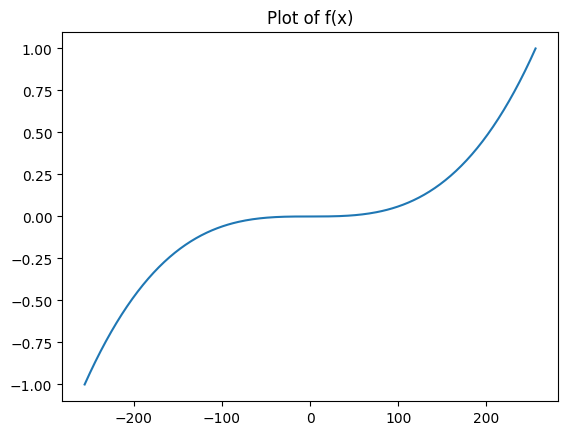

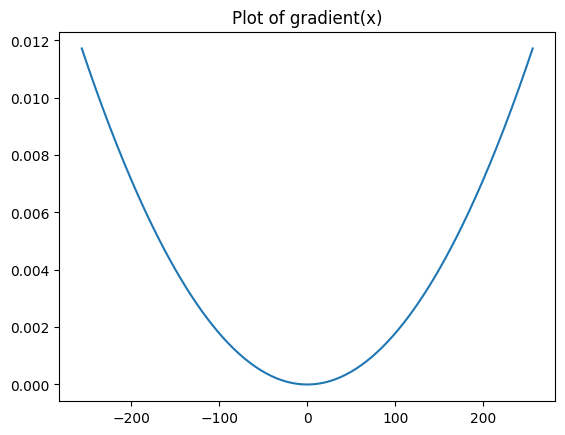

In [14]:
import numpy as np


n_qubits=8
# out_qubits=8


# def f(x):
#     return (np.sin(x) + np.sin(10 * x / 3) + 2)/560

# def gradient_f(x):
#     return (np.cos(x) + (10/3)*np.cos(10 * x / 3))/560


factor = (2**(-n_qubits))

def f(x):
    return (x*factor)**3

def gradient_f(x):
    # ensure that all points are <= 1
    # return factor*2*(x*2**(-n_qubits))
    return 3*factor*(x*factor)**2


import matplotlib.pyplot as plt

num_points=2**n_qubits

x_t = np.linspace(-2**n_qubits,2**n_qubits,num_points,endpoint=True)

y_t = [ f(x_) for x_ in x_t ]


plt.plot(x_t,y_t)
plt.title("Plot of f(x)")
plt.show()

plt.plot(x_t, [gradient_f(x) for x in x_t])
plt.title("Plot of gradient(x)")
plt.show()

In [15]:
# need to make sure the sum is normalized or at least less than 1
print(f'sum of f(x)\'s = {sum([f(x) for x in x_t])}')
print(f'sum of d/dx of f(x)\'s = {sum([gradient_f(x) for x in x_t])}')
conj_sqrd = lambda x : np.conjugate(x) * x
print(f'sum of |e^(2*pi*2^n*f(x))|^2 = {sum([conj_sqrd(np.exp(2*np.pi*1j*(2**n_qubits)*f(x))) for x in x_t])}')
print(f'len of x_t = {len(x_t)}')

sum of f(x)'s = 5.10702591327572e-15
sum of d/dx of f(x)'s = 1.007843137254902
sum of |e^(2*pi*2^n*f(x))|^2 = (256+0j)
len of x_t = 256


In [16]:
print(min(y_t),max(y_t))

-1.0 1.0


In [17]:
# mapping 0 - 2^n_qubits to actual data points
fixBinary = lambda x : x[2:] if len(x)-2 == n_qubits else '0'*(n_qubits+2-len(x)) + x.split('b')[1]
binary = lambda x: fixBinary(bin(x))
BinaryToDigit = {binary(x): x for x in range(0,2**n_qubits)}

In [18]:
# used for the basis states
def nestedKronecker(args): # use "*args" to access an array of inputs
    import numpy as np
    assert len(args) >= 2
    temp = args[0]
    for arg in args[1:]:
        temp = np.kron(temp, arg)
    return temp

In [19]:
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit import QuantumCircuit,BasicAer,transpile
from qiskit.quantum_info.operators import Operator

#### We will apply the following algorithm below
![Continuation of Algorithm](./pics/improvedAlgo.png)

In [21]:
basis = {0: [1,0], 1: [0,1], '0': [1,0], '1': [0,1]}

createBasisVectorFromBinary = lambda binstr : nestedKronecker([basis[x] for x in binstr])

# phase used for phase oracle (normalized version)
getPhase = lambda x, sign : np.exp(sign*(2**n_qubits)*np.pi*1j*f(sign*x))

#building the phase oracle manually: sum exponential with outer product of possible states
positiveOracle = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
negativeOracle = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
for i in range(2**n_qubits):
    # basisVector = createBasisVectorFromBinary(binary(i))
    # same as: positiveOracle += getPhase(i, +1) * np.outer(basisVector, basisVector)
    positiveOracle[i][i] = getPhase(i, +1)
    # same as: negativeOracle += getPhase(i, -1) * np.outer(basisVector, basisVector)
    negativeOracle[i][i] = getPhase(i, -1)
combinedOracle = np.matmul(positiveOracle, negativeOracle)

It says we can create some g that is $\epsilon$ close to the gradient of $f(x)$ such that:

![g close to gradient of f](./pics/g-close-to-gradient.png)

If the function $f$ is a polynomial of degree k, then for m = $\lceil k/2 \rceil$, we get B=0 which gives O($\frac{k}{\epsilon} log(\frac{d}{p})$). If $2 \le k = O(log(d))$, then we get **exponential speedup** in comparison to Jordan's algorithm with relation to the dimension of the data "d". 


#### From Theorem 25:

![epsilon approximate gradient of f](./pics/epsilon-approx-gradient.png)

We can compute an approximate gradient with O(log(d/δ)) queries to $O^S_{g_{(2m)}}$ , where S = O($\frac{1}{\epsilon r}$).

![](./pics/O_S_g.png)

Thus $O^S_{g_{(2m)}}$ can be implemented using $O(\frac{log(m)}{\epsilon r} + m)$ (fractional) queries to $O_f$. By choosing $m = log(c\sqrt{d}/\epsilon)$ the query complexity acheives, up to logarithmic factors the desired $1/\epsilon$ scaling in the precision paramter and also the $\sqrt{d}$ scaling with the dimension. This improves the results for Jordan's algorithm both quantitatively and qualitatively.